In [1]:
import argparse
import json
import os
import pdb
import pickle
import random
import time
from collections import OrderedDict
from Process_Data.Datasets.LmdbDataset import Hdf5DelectDataset
import Process_Data.constants as c
import h5py

import numpy as np
import torch
import torch._utils
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from kaldi_io import read_mat
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

from Define_Model.SoftmaxLoss import AngleLinear, AdditiveMarginLinear
# from Define_Model.model import PairwiseDistance
from Process_Data.Datasets.KaldiDataset import ScriptTrainDataset, \
    ScriptTestDataset, ScriptValidDataset
from Process_Data.audio_processing import ConcateOrgInput, mvnormal, ConcateVarInput
from TrainAndTest.common_func import create_model, load_model_args, args_model, args_parse
from python_speech_features import hz2mel, mel2hz

/home/yangwenhao/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
seed = 123456
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
lstm_path = '/home/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch'

In [4]:
transform = transforms.Compose([
    ConcateOrgInput(remove_vad=False),
])

In [ ]:
# model_dir = 'ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456'

model_dir = 'ThinResNet34/Mean_batch128_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/vox1/wave_fb80_dist2/123456'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir
# check_yaml = check_path + '/model.2022.07.20.yaml'
check_yaml = check_path + '/model.2023.06.06.yaml'

In [5]:
# model_dir = 'ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456'

model_dir = 'ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_chn32_wd5e5_varesmix8/arcsoft_sgd_rop/vox2/wave_fb80_dist/123456'
train_set = 'vox2'
check_path = root_path +  '/Data/checkpoint/' + model_dir
# check_yaml = check_path + '/model.2022.07.20.yaml'
check_yaml = check_path + '/model.2023.06.07.yaml'

In [6]:
# select_input_dir = root_path +  '/Data/gradient/{}/{}_dev4'.format(model_dir, train_set)
select_input_dir = root_path +  '/Data/gradient/' + 'ThinResNet34/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456' + '/{}_dev4'.format(train_set)

In [7]:
train_dir = Hdf5DelectDataset(select_dir=select_input_dir, 
                              transform=transform)

kwargs = {'num_workers': 8, 'pin_memory': False} 
train_loader = DataLoader(train_dir, batch_size=1, shuffle=False, **kwargs)

Examples uids:  [['id00012-21Uxsk56VDQ-00001', 0], ['id00012-21Uxsk56VDQ-00002', 0]]


In [8]:
model_kwargs = load_model_args(check_yaml)
if 'embedding_model' in model_kwargs:
    model = model_kwargs['embedding_model']
    model.classifier = model_kwargs['classifier']
else:
    model = create_model(model_kwargs['model'], **model_kwargs)

In [9]:
resume_path = check_path + '/checkpoint_{}.pth'

# ep = 15 # Load model from Checkpoint file
ep = 19 # Load model from Checkpoint file
# ep = 26 # Load model from Checkpoint file

if os.path.isfile(resume_path.format(ep)):
    
    checkpoint = torch.load(resume_path.format(ep))
    checkpoint_state_dict = checkpoint['state_dict']
    if isinstance(checkpoint_state_dict, tuple):
        checkpoint_state_dict = checkpoint_state_dict[0]

    filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
    if list(filtered.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in filtered.items():
            name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
            new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。

        model.load_state_dict(new_state_dict)
    else:
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)

In [10]:
trans = model.input_mask[0]
model.input_mask.__delitem__(0)
transform.transforms.append(trans)

model = model.cuda()
model.return_embeddings = False

In [11]:
transform.transforms

 MelFbankLayer(sr=16000, num_filter=80, stretch_ratio=1.00)]

In [12]:
from Process_Data.audio_processing import read_WaveInt
import shap

In [13]:
baseline_file = '/home/yangwenhao/project/lstm_speaker_verification/data/{}/dev/baselines.txt'.format(train_set)
baselines = [] 
with open(baseline_file, 'r') as f:
    for l in f.readlines():
        _, upath = l.split()
        the_data = read_WaveInt(upath)
        the_data = trans(torch.tensor(the_data).reshape(1, 1, -1).float())
        baselines.append(the_data)

# baselines = torch.cat(baselines, dim=-2).mean(dim=-2, keepdim=True) 

In [14]:
def padding_baselines(data, baselines):
    this_baselinses = []
    for the_data in baselines:
        while the_data.shape[1] < data.shape[-2]:
            the_data = np.concatenate([the_data, the_data], axis=1)
        
        the_data = torch.tensor(the_data[:, :data.shape[-2]]).float().unsqueeze(0)
        this_baselinses.append(the_data)
        
    return torch.cat(this_baselinses, dim=0)

In [15]:
extract_path = root_path +  '/Data/gradient/{}/epoch_{}_var/exptgrad_soft'.format(model_dir, ep)
file_dir = extract_path
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [20]:
class model_forward():
    def __init__(self, model):
        self.model = model
        pass
    
    def __call__(self, data):
        logits,_ = self.model(data)
        
        return logits

In [18]:
model.eval()
# explainer = shap.GradientExplainer((model), baselines, local_smoothing=0.5)
# shap_values,indexes = explainer.shap_values(norm_to_explain, ranked_outputs=2, nsamples=200)

pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=50)

  0%|                   | 0/23976 [00:00<?, ?it/s]

In [ ]:
model

In [19]:
grad_file = file_dir + '/grad.h5py'
with h5py.File(grad_file, 'w') as gf:
    for batch_idx, (datas, label, uid) in pbar:
        data_lenght = datas.shape[-2]
        # max_inputs = max(max_inputs, data.shape[-2])
        max_lenght =  4 * c.NUM_FRAMES_SPECT
        if datas.shape[2] >= max_lenght:
            num_segs = int(np.ceil(datas.shape[2] / max_lenght))
            if data.shape[2] < (num_segs*max_lenght):
                datas = torch.cat([datas, datas], dim=-2)
                datas = datas[:,:,:int(num_segs*max_lenght)]

            datas = datas.chunk(num_segs, dim=2)
            # data = torch.cat(x, dim=0)
        else:
            datas = [datas]
        
        grads = []
        for data in datas:
            baseline = padding_baselines(data, baselines)
            explainer = shap.GradientExplainer(model, baseline.cuda(), local_smoothing=0.5)
            shap_values,indexes = explainer.shap_values(data.cuda(),
                                                        ranked_outputs=1,
                                                        nsamples=200)
            # break
            grads.append(shap_values[0].squeeze().astype(np.float32))
        
        grad = np.concatenate(grads, axis=0)[:data_lenght]
        # print(grad.shape)   
        gf.create_dataset(uid[0], data=grad)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|████| 23976/23976 [10:22:41<00:00,  1.56s/it]


In [29]:
import argparse
import pathlib
import pickle
import h5py
import random
import json
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy import interpolate

%matplotlib inline

In [20]:
# extract_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_50_var_50/epoch_50'
lstm_path = '/home/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch/Data/gradient'
cam_method = 'exptgrad_soft' #   fullgrad grad_cam_pp integrad layer_cam gradientshap_soft
# model_dir = 'ThinResNet34/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456'

extract_path = root_path + '/%s/epoch_%d_var/%s' % (model_dir, ep, cam_method)
input_path = root_path + '/%s/%s_dev4' % (model_dir, train_set)

# Training options
feat_dim = 80 #161
samples = 23976
acoustic_feature = 'spectrogram' # choices=['fbank', 'spectrogram', 'mfcc'],
seed = 123456

random.seed(seed)
np.random.seed(seed)

In [21]:
def read_hdf5(reader, key):
    with h5py.File(reader, 'r') as r:
        data_flat = r.get(key)[:]
        return data_flat
    
def mean_norm(grad):
    return np.abs(grad).mean(axis=0)

def var_norm(grad):
    return grad.var(axis=0)

def clip_mean_norm(grad):
    return np.clip(grad, a_min=0, a_max=None).mean(axis=0)

def sum_norm(grad):
    cam = np.abs(grad).sum(axis=0)
    cam = (cam - cam.min()) / (cam.max()-cam.min() + 1e-6)
    return cam

def clip_sum_norm(grad):
    cam = np.clip(grad, a_min=0, a_max=None).sum(axis=0)
    cam = (cam - cam.min()) / (cam.max()-cam.min() + 1e-6)
    return cam

def sum_clip_norm(grad):
    cam = np.clip(grad.sum(axis=0), a_min=0, a_max=None)
    cam = (cam - cam.min()) / (cam.max()-cam.min() + 1e-6)
    return cam

In [22]:
uid2spk = {}
with open(lstm_path + '/data/%s/dev/utt2spk'%train_set, 'r') as f:
    for l in f.readlines():
        uid, sid = l.split()
        # if uid in some_data:
        uid2spk[uid] = sid
    
sid2gender = {}
with open(lstm_path + '/data/%s/dev/spk2gender_bcp'%train_set, 'r') as f:
    for l in f.readlines():
        sid, gender = l.split()
        sid2gender[sid] = gender
        
uid2gender = {}
for uid in uid2spk:
    this_sid = uid2spk[uid]
    uid2gender[uid] = sid2gender[this_sid] if this_sid in sid2gender else 'null'

In [24]:
# load selected input uids
# dir_path = pathlib.Path(extract_path)
# print('Path: %s' % str(dir_path))
data_reader = select_input_dir + '/data.h5py'
uid_reader = select_input_dir + '/uid_idx.json'

assert os.path.exists(data_reader)
assert os.path.exists(uid_reader)

with open(uid_reader, 'r') as f:
    uididx = json.load(f)
    
grad_reader = extract_path + '/grad.h5py'
assert os.path.exists(grad_reader)

some_data = set([uid for uid,idx in uididx])
print("Length of data: ", len(some_data))

Length of data:  23976


In [25]:
def get_data_grad(uid):
    data = read_hdf5(data_reader, uid)
    grad = read_hdf5(grad_reader, uid)
    return data, grad

In [35]:
grad_input_f = np.zeros((feat_dim))
grad_input_m = np.zeros((feat_dim))
grad_input = np.zeros((feat_dim))

norm_func = clip_sum_norm
males,females = 0,0
for uid in tqdm(some_data, ncols=50):
    gender = uid2gender[uid]
    # data, grad = get_data_grad(uid)
    grad = read_hdf5(grad_reader, uid)
    if np.isnan(grad).sum()>0:
        print("Skip %s with shape %s" %(uid, str(grad.shape)))
        continue
        
    if gender == 'f':
        females += 1
        grad_input_f  += norm_func(grad)
    else:
        males += 1
        grad_input_m  += norm_func(grad)
    
    grad_input += norm_func(grad)
        
grad_input_f /= females
grad_input_m /= males
grad_input /= females + males
# print(grad_input_f, grad_input_m)

100%|██████| 23976/23976 [00:24<00:00, 982.57it/s]


In [27]:
print(females, males)

9248 14728


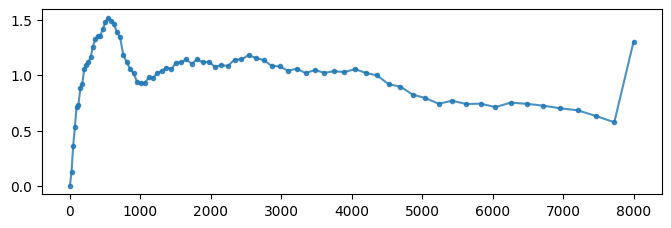

In [36]:
plt.figure(figsize=(8, 2.4))
# x = np.linspace(0, 8000, 161)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)

alpha = 0.8

for i,(f, m, r) in enumerate([(grad_input_f, grad_input_m, grad_input)]):
    # plt.plot(x, m/m.mean(), alpha=alpha)
    # plt.plot(x, f/f.mean(), alpha=alpha)
    plt.plot(x, r/r.mean(), alpha=alpha, marker='.')
    # y /= y.sum()
    # plt.legend(['male', 'female', 'overall'])
    
plt.savefig('../imgs/%s_%s_%s.png'%(train_set, cam_method, str(norm_func).split()[1]), bbox_inches='tight')